In [2]:
import sys
sys.path.append("../../../")

## 数据

In [3]:
import matplotlib.pyplot as plt
from pylib.utils.functions_for_classification import mixed_2d_2cls, plot_scatter

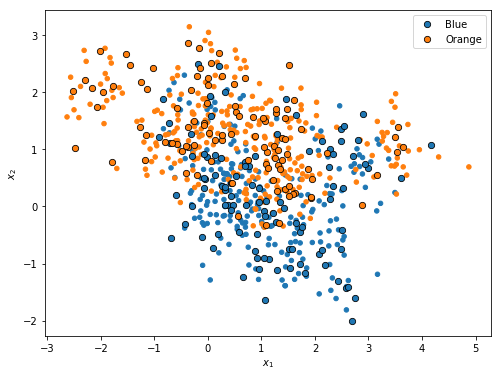

In [4]:
X_train, X_test, y_train, y_test = mixed_2d_2cls()
plt.figure(figsize=(8, 6))
plot_scatter(X_train, y_train, X_test, y_test)
plt.show()

## 自适应提升

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from pylib.utils.functions_for_classification import plot_decision_boundary
import numpy as np
from copy import deepcopy

In [9]:
class AdaBoost(BaseEstimator, ClassifierMixin):
    """
    自适应提升
    
    参数
    ----
    n_estimators: 决策树桩的数量
    weights: 每个决策桩的权重
    store_losses: 是否存储历史的损失值
    
    属性
    ----
    estimators: 存储决策桩
    weights: 存储每个决策桩的权重
    loss_history: 存储历史的损失值
    """
    def __init__(self, n_estimators=50, learning_rate=1.0, store_losses=False):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.store_losses = store_losses
        
    def fit(self, X, y):
        y = np.where(y >= 1, 1, -1)
        n, p = X.shape
        w = np.repeat(1/ n , n)  # 定义样本权重
        M = self.n_estimators
        self.estimators = []
        self.weights = []
        self.loss_history = []
        for m in range(M):      
            base_learner = DecisionTreeClassifier(max_depth=1)
            base_learner.fit(X, y, sample_weight=w)  # 用基本学习器拟合样本
            ym_pred = base_learner.predict(X)
            errm = np.sum(np.multiply(w, y != ym_pred)) / np.sum(w)  # 加权的误分类误差
            alpham = np.log((1 - errm) / errm)  # 计算每个学习器的权重
            w = self.learning_rate * np.multiply(w, np.exp(alpham * (y != ym_pred))) # 更新样本权重           
            self.weights.append(alpham)
            self.estimators.append(base_learner)
            if self.store_losses:
                ym_pred_weighted = self.predict(X)
                self.loss_history.append(np.sum(np.exp(-np.multiply(y, np.where(ym_pred_weighted>0, 1, -1)))))
            
        return self

    def predict(self,X):
        y_pred = 0
        for learner, alpham in zip(self.estimators, self.weights):
            # 计算加权预测值
            ym_pred = learner.predict(X)
            y_pred += ym_pred * alpham
        y_pred = np.where(y_pred > 0,1,0)
        
        return y_pred 
    

In [10]:
adaboost = AdaBoost(n_estimators=200, learning_rate=0.5,
                    store_losses=True)
adaboost.fit(X_train, y_train)

AdaBoost(learning_rate=0.5, n_estimators=200, store_losses=True)

In [11]:
train_err = 1 - adaboost.score(X_train, y_train)
print("训练样本误差：{:.3f}".format(train_err))

训练样本误差：0.105


In [43]:
test_err = 1 - adaboost.score(X_test, y_test)
print("测试样本误差：{:.3f}".format(test_err))

测试样本误差：0.242


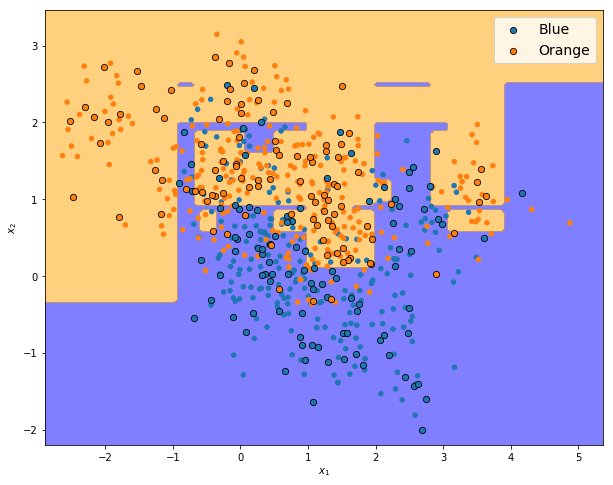

In [75]:
# 画出决策边界
plt.figure(figsize=(10, 8))
plot_decision_boundary(X_train, y_train, X_test, y_test, adaboost)
plt.show()

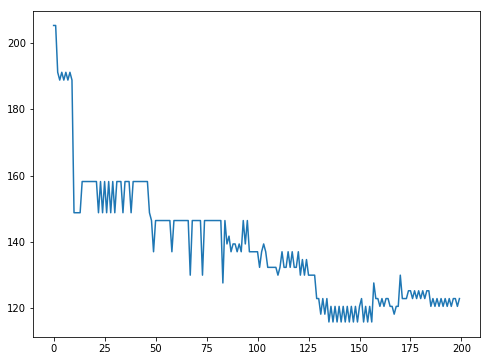

In [50]:
# 绘制历史损失值
loss_history = adaboost.loss_history
plt.figure(figsize=(8, 6))
plt.plot(range(len(loss_history)), loss_history)
plt.show()

In [22]:
weights = adaboost.weights
print("贡献最大的前10课树桩：{}".format(np.argsort(weights)[::-1][:10]))

贡献最大的前10课树桩：[ 0  1  2  3 10 14 23 11 12 48]


### 查看依次分类的情况

In [ ]:
from matplotlib.colors import ListedColormap

In [52]:
learners = adaboost.estimators
weights = adaboost.weights

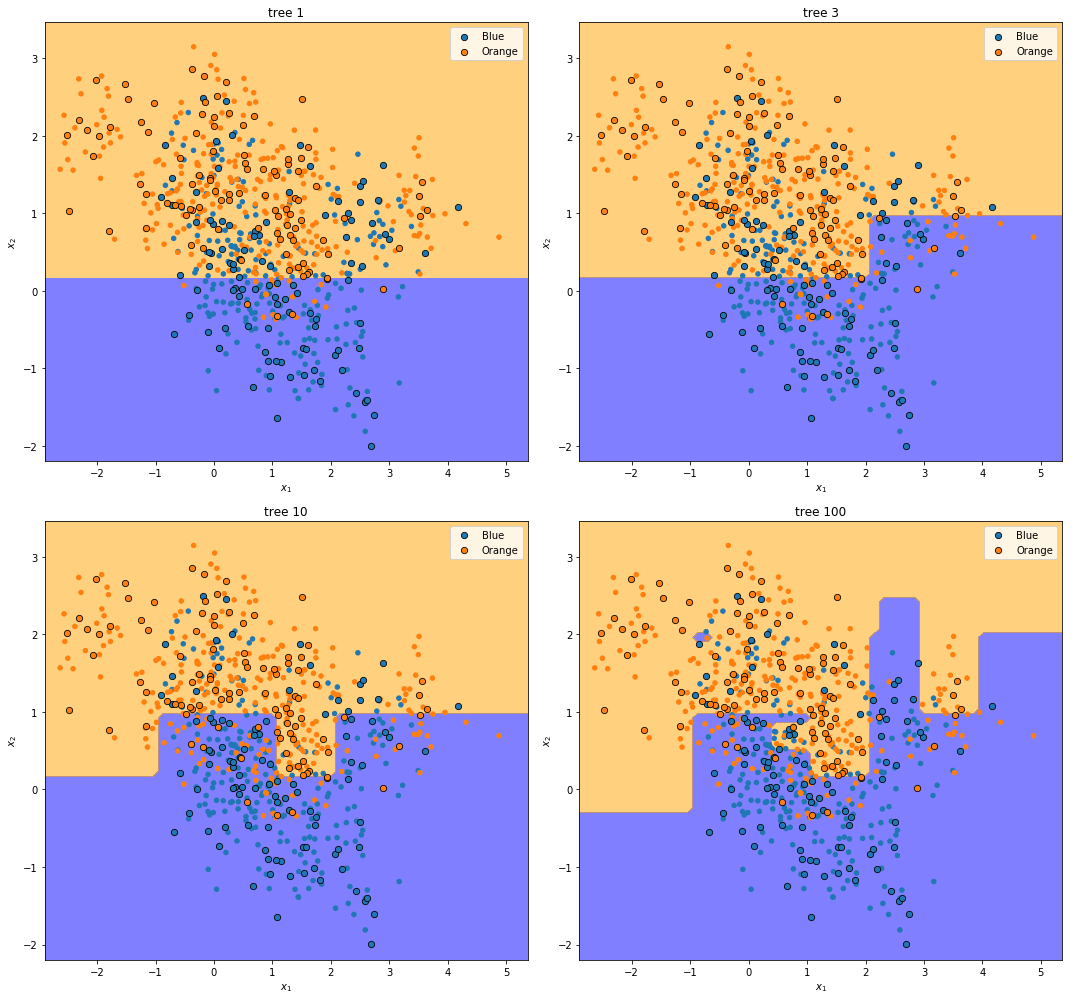

In [74]:
colors = ['blue', 'orange']
cmap = ListedColormap(colors)
h = 50
x1n_min = 1.1 * min(X_train[:, 0].min(), X_test[:, 0].min())
x1n_max = 1.1 * max(X_train[:, 0].max(), X_test[:, 0].max())
x2n_min = 1.1 * min(X_train[:, 1].min(), X_test[:, 1].min())
x2n_max = 1.1 * max(X_train[:, 1].max(), X_test[:, 1].max())
x1n = np.linspace(x1n_min, x1n_max, h)
x2n = np.linspace(x2n_min, x2n_max, h)
xx1n, xx2n = np.meshgrid(x1n, x2n)
X = np.c_[xx1n.ravel(), xx2n.ravel()]

num = [1, 3, 10, 100]
plt.figure(figsize=(15, 14))
for i, j in enumerate(num):
    yy = 0
    for learner, weight in zip(learners[:j+1], weights[:j+1]):
        yi_pred = np.array([learner.predict(xx.reshape(1, -1)) for xx in X]).reshape(xx1n.shape)
        yy += weight * yi_pred
    yy = np.where(yy > 0,1,0)
    plt.subplot(int("22{}".format(i+1)))
    plot_scatter(X_train, y_train, X_test, y_test)
    plt.contourf(xx1n, xx2n, yy, levels=1, cmap=cmap, alpha=0.5, zorder=-1)
    plt.title("tree {}".format(j))
plt.tight_layout()
plt.show()